# Predicting High School Student Performance 

## Step 1: Loading and brief exploration

In [ ]:
############# Install these if not already installed #########
#! pip install mixed-naive-bayes 
#! conda install -c pchrapka scikit-feature
##############################################################

In [1]:
import pandas as pd
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# read in the data
port_df = pd.read_csv("student-por.csv", sep=";")
maths_df = pd.read_csv("student-mat.csv", sep=";")

# glance at the dataset
port_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [2]:
# get nuber of rows, columns and check for N/A
print("Portugese: {}; Missing values: {}".format(port_df.shape, port_df.isnull().values.any()))
print("Maths: {}; Missing values: {}".format(maths_df.shape, maths_df.isnull().values.any()))

Portugese: (649, 33); Missing values: False
Maths: (395, 33); Missing values: False


Neither have missing values, but the Portugese set has more records. Let's examine the grade distribution:

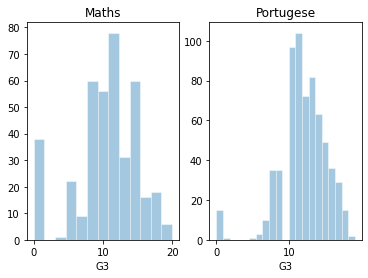

In [4]:
# plot G3 to check the distribution and if values make sense (are between 0 and 20)
import matplotlib.pyplot as plt
import seaborn as sn
fig, ax =plt.subplots(1,2)
sn.set(color_codes=True)
sn.distplot(maths_df['G3'], kde=False, ax=ax[0]).set_title('Maths')
sn.distplot(port_df['G3'], kde=False, ax=ax[1]).set_title('Portugese')
fig.show()

As expected, the grades follow the Bell Curve. Interestingly, a lot more people performed extremely poorly in Maths than in Portugese. 

Since we want to convert G3 to a discrete scale, the Portugese set is more suitable as it is much larger (Using the Maths dataset will lead to highly imbalanced classes or a very small balanced set should we choose to undersample). From now on, we will proceed with the Portugese dataset only.

## Step 2: Pre-processing

For the classification-type problem, we need to:
1. Recode G3 into discrete scale:
    * 0 <= G3 < 10 - `Very poor to poor`
    * 10 <= G3 < 16 - `Sufficient to good`
    * 16 <= G3 <= 20 - `Very good to excellent`
2. Encode text variables as numeric (sklearn only accepts numeric values). 
3. Split the dataset into two: one without first and second period grades (G1 and G2) and one with the first period grade only. This is to make the problem more interesting - it will be easier to predict final performance if the student's past performance is known, but it's more exciting to try and predict the performance without knowing past grades at all. 

We already have some ordinal attributes (e.g. Mother's education, Father's education are between 1 and 4 (from no education to higher education)). A potential issue with mapping categories to numeric values is that some of the variables will (incorrectly) become ordinal. E.g. Mother's job:

In [6]:
print(port_df["Mjob"].head)

<bound method NDFrame.head of 0       at_home
1       at_home
2       at_home
3        health
4         other
         ...   
644    services
645     teacher
646       other
647    services
648    services
Name: Mjob, Length: 649, dtype: object>


Encoding `Mjob` would incorrectly imply that one occupation is "bigger/higher" than another. The distance-based classifier will then give more weight to values that happen to be next to each other (e.g. two occupation encoded as 3 and 4 will get more weighting thatn occupations 1 and 4). A solution to this is using one hot-encoding, but it has some flaws, including introduction of multicollinearity (especially damaging for a Naive Bayes classifier). 

With that in mind, we will use standard label encoding and adjust depending on the classifier. 

In [81]:
#<------------------------------- Convert grade to a discrete scale ------------------------------->#
# Conversion intervals based on Portugal's grade classification system (condensed)

# Actual categories --- these were not used in the end to avoid fragmentationa nd imbalance
'''
conditions = [
    (df['G3'] >= 0) & (df['G3'] < 7),
    (df['G3'] >= 7) & (df['G3'] < 10),
    (df['G3'] >= 10) & (df['G3'] < 14),
    (df['G3'] >= 14) & (df['G3'] < 16),
    (df['G3'] >= 16) & (df['G3'] < 18),
    (df['G3'] >= 18) & (df['G3'] <= 20)
]
choices = ['very poor', 'poor', 'sufficient', 'good', 'very good', 'excellent']
'''

def convert_grade(df):
    # a less fragmented classification with groups lumped together
    conditions = [
        (df['G3'] >= 0) & (df['G3'] < 10),
        (df['G3'] >= 10) & (df['G3'] < 16),
        (df['G3'] >= 16) & (df['G3'] <= 20)
    ]
    # labels to match the grade intervals
    choices = [0, 1, 2]
    # corresponding grade classifications
    df['G3_discrete'] = np.select(conditions, choices)
    
    # mark ordinal attributes as categorical, not numeric
    attributes = list(df)
    # Exclude the attributes that should be treated as numeric
    attributes = [a for a in attributes if a not in ('age', 'absences', 'G3', 'G1', 'G3_discrete')]
    for attribute in attributes:
        df[attribute] = df[attribute].astype('category',copy=False)
    # no longer need G3
    #df=df.drop(['G3'], axis=1)
    return df

#<------------------------------- Change labels to numeric values ------------------------------->#

# sklearn only accepts numeric values; encode the categorical attributes 
def label_encode(df):
    # assuming the categorical attributes have been marked accordingly
    labels = df.select_dtypes(include=['category'])

    # object-type attributes are strings - we need to recode these
    #labels = df.select_dtypes(include = "object").columns
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for l in labels:
        df[l] = le.fit_transform(df[l].astype(str))
    return df


# Subset without G1 and G2
df_no_grade = port_df.drop(['G1', 'G2'], axis = 1)
# Subset without G2
df_grade = port_df.drop(['G2'], axis = 1)

# process the frames and get rid of G3 column as it is no longer needed
df_no_grade = label_encode(convert_grade(df_no_grade))
df_grade = label_encode(convert_grade(df_grade))

In [82]:
# check class counts
df_grade.groupby('G3_discrete')['G3_discrete'].count()

G3_discrete
0    100
1    467
2     82
Name: G3_discrete, dtype: int64

Training on unbalanced samples makes most classifiers unable to generalise well and identify the less frequent classes - they will tend to label everything as the dominant class as it still gives good overall accuracy although it's not particularly useful. We will use undersampling to create balanced subset.

In [83]:
def balance_sample(df):
    class_2 = df[df['G3_discrete'] == 2 ] 
    # randomly sample from the more prevalent classess to match the length of class 1
    # specify a random state to generate the same sample every time we run the program - to monitor accuracy
    class_0 = df[df['G3_discrete'] == 0 ].sample(len(class_2), random_state = 0)
    class_1 = df[df['G3_discrete'] == 1 ].sample(len(class_2), random_state = 0) 
    frames = [class_1, class_2, class_0]
    balanced_sample = pd.concat(frames)
    return balanced_sample

df_grade = balance_sample(df_grade)
df_no_grade = balance_sample(df_no_grade)

## Step 3: Feature selection

Having a large number of attributes - 31 excluding G3 and G2 - can lead to overfitting, and it is unlikely that all of them are relevant to the student performance. High dimensionality also slows down training, although in our case the impact is not as sever since the  dataset is relatively small.

We will use feature selection to filter out attributes that don't have a lot of impact on the target class.
We are using the chi-squared statistic - the function will perform a chi-sqared test for independence and select k results witht he highest statistic (i.e. rejecting the hypothesis of independence). These attributes will have most impact on grade.

In [201]:
from sklearn.feature_selection import SelectKBest, chi2
from skfeature.function.statistical_based import CFS

#<-------------------- Feature Selection (Chi-squared) ------------------------------------------->
def fs_chi(df,n_features):
    X = df.drop(['G3_discrete', 'G3'], axis=1)
    ## for random forest
    #X = balanced_sample.drop(['G3_discrete','G3_binary', 'G3', 'reason','school','Mjob','Fjob'], axis=1)
    y = df['G3_discrete']
    # 14 features had the best result for bot NB and Random Forest
    selector = SelectKBest(chi2, k=n_features)
    feature_data = selector.fit_transform(X, y)
    # map selected features back to original names
    mask=selector.get_support()
    feature_names = X.columns[mask]
    df_selected = pd.DataFrame(feature_data, columns=feature_names)
    return df_selected

# correlation-based feature selection picks attributes that are strongly related to the target 
# but uncorrelated with one another - this should help meet the Naive Bayes assumption of independence
#<-------------------- Correlation-Based Feature Selection -------------------------------------->
def cfs(df):
    X_cfs = df.drop(['G3_discrete', 'G3'], axis=1)
    y = df['G3']
    idx = CFS.cfs(X_cfs.values, y)
    df_cfs = df.iloc[:, idx]
    return df_cfs

## Step 4: Classifiers

### Naive Bayes

In [99]:
from sklearn.model_selection import train_test_split
from mixed_naive_bayes import MixedNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def NB(df,y, stats=True):
    # split into training and testing, use stratification to get same number of each class in splits   
    train_x, test_x, train_y, test_y = train_test_split(df, y, stratify=y, test_size=0.2, random_state=42)
    # get list of categorical attributes for mixed NB
    indices=[]
    attributes = list(train_x)
    attributes = [a for a in attributes if a not in ('age', 'absences', 'G1', 'G2')]
    for attr in attributes:
        indices.append(train_x.columns.get_loc(attr))
        
    # create classifier
    model = MixedNB(categorical_features=indices)
    # train classifier
    model.fit(train_x,train_y)
    # predict using test set
    predictions = model.predict(test_x)
    # calculate accuracy of the model
    print("\nOverall accuracy: {}\n".format(sum(predictions==test_y)/len(test_y)))
    # create confusion matrix
    
    # show full report and cm
    if stats:
        cm=confusion_matrix(test_y,predictions)
        df_cm = pd.DataFrame(cm, range(3), range(3))
        sn.set(font_scale=1.2) 
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="summer") 

        print(classification_report(test_y, predictions))

[2 5 5 4 4 4 5 5]

Overall accuracy: 0.86

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.86      0.71      0.77        17
           2       0.94      0.94      0.94        17

   micro avg       0.86      0.86      0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50



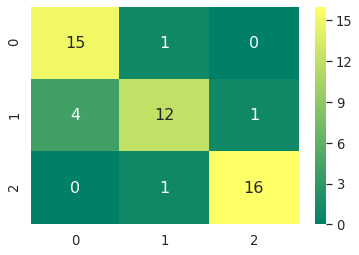

In [129]:
# Dataset with G1
# 10 features works best
NB(fs_chi(df_grade,n_features=10),df_grade['G3_discrete'])

[2 5 4 4 5]

Overall accuracy: 0.74

              precision    recall  f1-score   support

           0       0.76      0.81      0.79        16
           1       0.67      0.59      0.62        17
           2       0.78      0.82      0.80        17

   micro avg       0.74      0.74      0.74        50
   macro avg       0.74      0.74      0.74        50
weighted avg       0.74      0.74      0.74        50



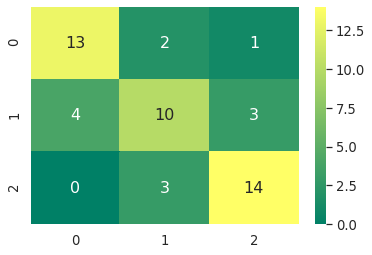

In [112]:
# Dataset without grades
# this model work better with fewer features
NB(fs_chi(df_no_grade, n_features = 6),df_no_grade['G3_discrete'])

As expected, knowing at least one previous grade significanttly improves the accuracy. The nice thing is that even the model without grades is still performing well - 70% accuracy is great considering that randomly picking the class is 30% accuarte (in a balanced sample).

Both models are reasonably good at predicting the minority classes - around 86% precision for the poorest and the best performance in classifier 1 and 67% in classifier 2. Recall, i.e. the number of true "positives" over the true number of "positive" exaples (positive is a given class), is also reasonably good in both models. Arguably, it is a more important metric in our case as in the real world we would want to be able to identify the "outliers" (e.g. students at a risk of failing). The second model's ability to detect fringe cases is certainly loewer than that of the first, but is still good given that we knew nothing of the student's performance tendencies.

Finally, let's look at the selected features:

In [115]:
# selected features -- model 1 (with G1)
print(fs_chi(df_grade, 10).info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   school     246 non-null    int64
 1   Medu       246 non-null    int64
 2   Mjob       246 non-null    int64
 3   reason     246 non-null    int64
 4   studytime  246 non-null    int64
 5   failures   246 non-null    int64
 6   Dalc       246 non-null    int64
 7   Walc       246 non-null    int64
 8   absences   246 non-null    int64
 9   G1         246 non-null    int64
dtypes: int64(10)
memory usage: 19.3 KB
None


In [121]:
# selected features -- model 2 (no grades)
print(fs_chi(df_no_grade, 6).info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   school     246 non-null    int64
 1   Medu       246 non-null    int64
 2   studytime  246 non-null    int64
 3   failures   246 non-null    int64
 4   Walc       246 non-null    int64
 5   absences   246 non-null    int64
dtypes: int64(6)
memory usage: 11.7 KB
None


Feature selection gave us simpler models (10 and 6 features form model 1 and model 2 respectively). We will also try correlation-based feature selection to remove multicollinearity.

In [127]:
# Model 1 using CFS
NB(cfs(df_grade),df_grade['G3_discrete'],False)
cfs(df_grade).info()

[4 5 5]

Overall accuracy: 0.84

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 593 to 443
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   G1        246 non-null    int64
 1   absences  246 non-null    int64
 2   failures  246 non-null    int64
 3   Fedu      246 non-null    int64
 4   goout     246 non-null    int64
 5   age       246 non-null    int64
dtypes: int64(6)
memory usage: 13.5 KB


In [128]:
# Model 2 using CFS
cfs = cfs(df_no_grade)
NB(cfs,df_no_grade['G3_discrete'], False)
cfs.info()

[4 5 5 5 5 5 2 4 5 4 5 5 2 5 5 2 2 3 4]

Overall accuracy: 0.7

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 593 to 443
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   absences    246 non-null    int64
 1   failures    246 non-null    int64
 2   Fedu        246 non-null    int64
 3   age         246 non-null    int64
 4   goout       246 non-null    int64
 5   Medu        246 non-null    int64
 6   Dalc        246 non-null    int64
 7   health      246 non-null    int64
 8   higher      246 non-null    int64
 9   reason      246 non-null    int64
 10  freetime    246 non-null    int64
 11  studytime   246 non-null    int64
 12  Mjob        246 non-null    int64
 13  famrel      246 non-null    int64
 14  school      246 non-null    int64
 15  Walc        246 non-null    int64
 16  Fjob        246 non-null    int64
 17  nursery     246 non-null    int64
 18  schoolsup   246 non-null    int64
 19  guard

Models with cfs performed slightly worse than those with more features. It is also worth noting that Mixed NB assumes that all continuous variables are normally distributed. This is not necessarily the case, e.g. with `absences`:

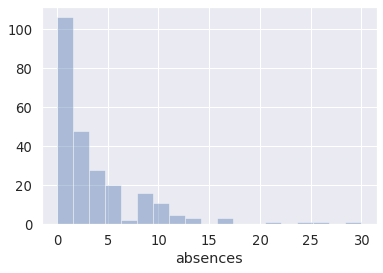

In [130]:
sn.distplot(df_grade['absences'], kde=False)

### Random forest

In [220]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

def RF(df, stats=True, model=None):
    y = df_grade['G3_discrete']
    # split into training and testing, use stratification to get same number of each class in splits
    train_x, test_x, train_y, test_y = train_test_split(df, y, test_size=0.2, stratify = y, random_state=42)

    # the attributes are measured on different scales, we need to scale them to be between 0 and 1 
    # this wasn't an issue with NB as it works with proabilites and is not affected by the magnitudes
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)

    if model is None:
    # create a base model with 10 trees (by default uses gini to evaluate how good a split is)
        model = RandomForestClassifier(random_state = 42)
    else:
        model = model
    # train classifier
    model.fit(train_x, train_y)
    # evaluate classifier as before
    predictions = model.predict(test_x)
    print("\nOverall accuracy: {}\n".format(sum(predictions==test_y)/len(test_y)))
    
    if stats:
        cm=confusion_matrix(test_y,predictions)
        df_cm = pd.DataFrame(cm, range(3), range(3))
        sn.set(font_scale=1.4) # for label size
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="summer") # font size
        print(classification_report(test_y, predictions))


Overall accuracy: 0.82

              precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       0.79      0.65      0.71        17
           2       0.94      0.88      0.91        17

   micro avg       0.82      0.82      0.82        50
   macro avg       0.82      0.82      0.82        50
weighted avg       0.83      0.82      0.82        50



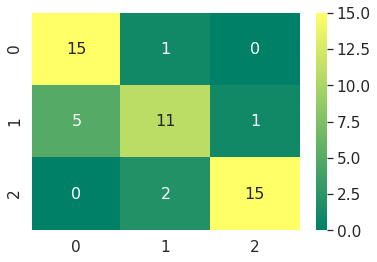

In [239]:
RF(fs_chi(df_grade,6))


Overall accuracy: 0.6

              precision    recall  f1-score   support

           0       0.73      0.69      0.71        16
           1       0.47      0.53      0.50        17
           2       0.62      0.59      0.61        17

   micro avg       0.60      0.60      0.60        50
   macro avg       0.61      0.60      0.61        50
weighted avg       0.61      0.60      0.60        50



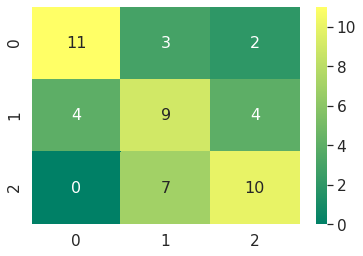

In [249]:
RF(fs_chi(df_no_grade,30)) # gives best peformance without feature selection

The default RF model performance isn't great, especially without G1. The hyperparameters that affect performance the most are the number of trees, evaluation method (we are using gini but another common one is entropy) and maximum tree depth. We will perform hyperparameter tuning using a grid of different hyperparameter values. Once the approximate best parameters are known, it will also be much easier to do some manual tuning.

In [222]:
# we can tune the hyperparameters (number of trees, depth, evaluation function etc.) with a Random Hyperparameter Grid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

criterion = ['entropy', 'gini']
# number of trees - 1000 seems to work well from just manual plugging in, anything below isn't good
n_estimators = [int(x) for x in np.linspace(start = 900, stop = 2000, num = 12)]
# max number of features considered for splitting at each node
max_features = ['sqrt', 'log2', 'auto']
# max tree depth - evaluate 10 common values
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# also evaluate having no limit on tree depth
max_depth.append(None)
# min number of examples needed to make a split
min_samples_split = [2, 5, 10]
# min number of examples in a leaf node
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# we will use random grid to search to evaluate different combaniations of hyperparameters
# create a grid of possible hyperparamenter values - this is our search space
random_grid = {'n_estimators': n_estimators,
               'criterion' : criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# the classifer
cv = RandomForestClassifier()
# go throgh 300 grid combinations, nd use 3-fold cross-validation to evaluate, show messages
rf_random = RandomizedSearchCV(estimator = cv, param_distributions = random_grid, 
                               n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_x, train_y)

In [223]:
# compare performance
base_model = RandomForestClassifier(random_state = 42)
base_model.fit(train_x, train_y)
predictions_base = base_model.predict(test_x)

best_model = rf_random.best_estimator_
predictions_best = best_model.predict(test_x)


print("Base model accuracy: {}".format(sum(predictions_base==test_y)/len(test_y))) 
print("With hyperparameter tuning: {}".format(sum(predictions_best==test_y)/len(test_y)))
print("Selected hyperparameters: \n")
print(rf_random.best_params_)

Base model accuracy: 0.74
With hyperparameter tuning: 0.8
Selected hyperparameters: 

{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': False}


Already some improvement in performance. Now that we have narrowed down the search space, we can perform a grid search to refine the parameters.

In [224]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [1000, 1100, 1200, 1300],
    'min_samples_leaf': [1,2,3, 4],
    'min_samples_split': [2, 3, 4],
    'max_depth': [2,3,4]
}
# Create a based model
rf = RandomForestClassifier()
# this search through the entire space, don't show messages. This will take around 2 minutes
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(train_x, train_y)

print("Selected hyperparameters: \n")
print(grid_search.best_params_)


Selected hyperparameters: 

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}



Overall accuracy: 0.86

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.86      0.71      0.77        17
           2       0.94      0.94      0.94        17

   micro avg       0.86      0.86      0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50



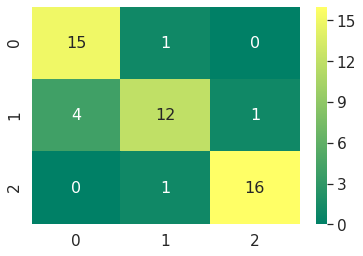

In [236]:
# our final model (with some manual tuning)
best_model = RandomForestClassifier(n_estimators = 1100, min_samples_leaf= 1,
     min_samples_split= 4, max_depth=3, random_state = 42)

RF(fs_chi(df_grade,8), model=best_model)


Overall accuracy: 0.72

              precision    recall  f1-score   support

           0       0.80      0.75      0.77        16
           1       0.69      0.53      0.60        17
           2       0.68      0.88      0.77        17

   micro avg       0.72      0.72      0.72        50
   macro avg       0.72      0.72      0.71        50
weighted avg       0.72      0.72      0.71        50



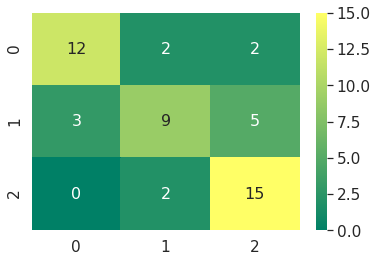

In [229]:
RF(df_no_grade.drop(['G3','G3_discrete'],axis=1), model = best_model)

Hyperparameter tuning gave a good improvement in accuracy for both models: 
* up **82 to 86%** in model 1
* up **60 to 72%** in model 2

## Aside: correlations

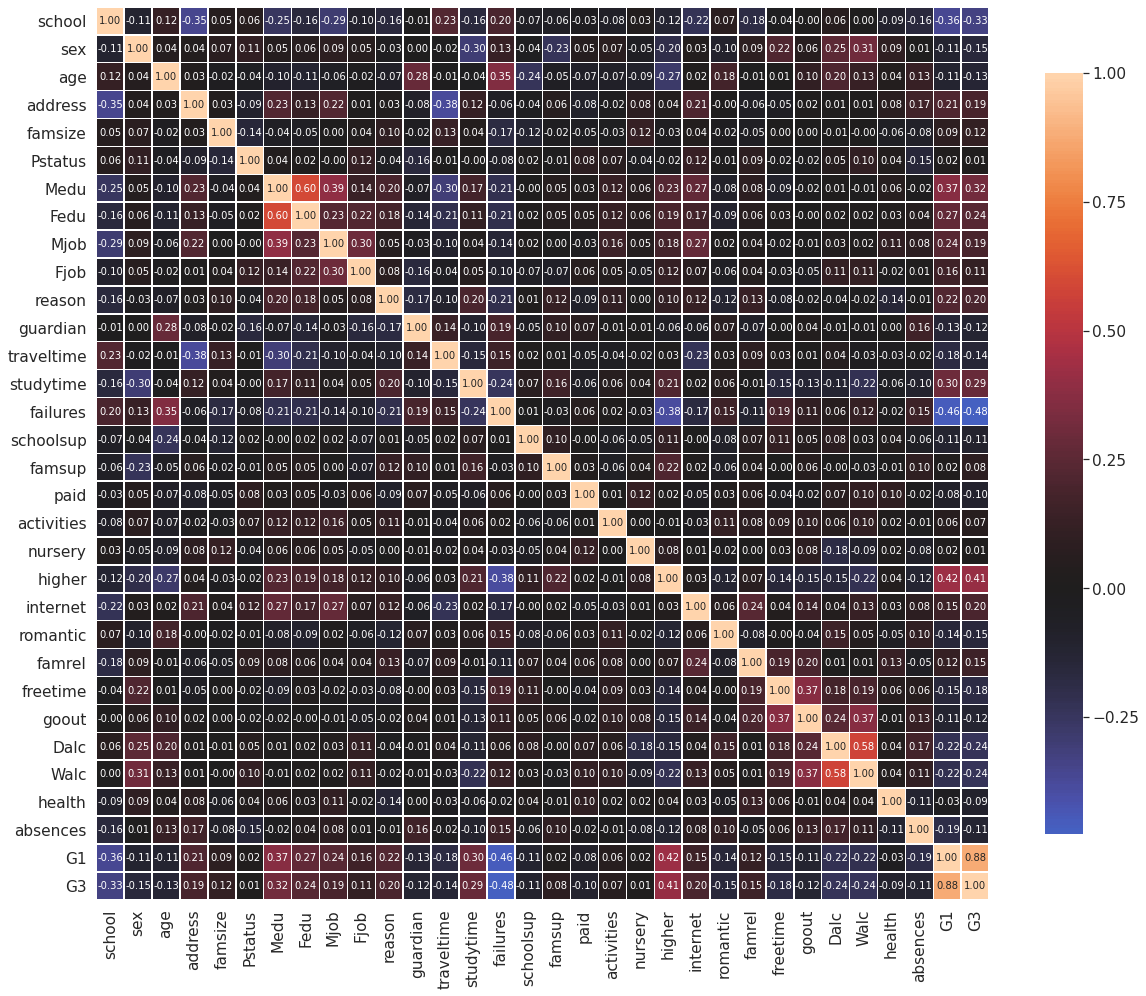

In [252]:
# Let's compute pairwise correlation cofefficient of all features and the variable of interest
import numpy as np

def correlation_heatmap(df):
    # compute pairwise correlation coefficients
    correlation = df.corr()
    fig, ax = plt.subplots(figsize=(20,20))
    # visualise the coefficients as a heatmap
    sns.heatmap(correlation, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70},  annot_kws={"size": 10})
    plt.show();
    
correlation_heatmap(df_grade.drop("G3_discrete",axis=1))

Wow! 

The bluer or redder the square, the stronger the correlation (positive or negative).

Looking at the correlation with the final grade:
* Parents' education, weekly study time, plans to take up higher education and G1 are some of the features that had a strong positive correlation with the final year grade. Those who attended nursery school also had a tendency to perform better.
* Number of past class failures, alcohol consumption and school had negative correlation with the grade. 

**Some other interesting features:**
* Men drank more than women and spend less time a week on study
* Drinkers and those with many class failures were less likely to want to take up higher education
* Mother's education had strong positive correlation with wanting to take up higher education